In [14]:
from sklearn.datasets import load_svmlight_file
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

In [15]:
train_file = "a9a"
valid_file = "a9at"
num_iter = 100  # 最大迭代次数
k = 200  # 每次训练的batch

In [16]:
def get_data(filename):
    # 读入数据
    data = load_svmlight_file(filename)
    X = data[0].toarray()
    y = data[1]
    count = X.shape[0]
    if filename == 'a9at':
        X = np.column_stack((X, np.zeros((count, 1))))
    np.c_[X, np.ones(count)]
    return [X, y]

In [17]:
def sigmoid(inx):
    return 1.0/(1.0+exp(-inx))

In [18]:
def compute_loss(weights, dataMatrix, classLabels):

    totalError = 0.0
    count = dataMatrix.shape[0]
    for i in range(0, count):
        h = sigmoid(sum(dataMatrix[i]*weights))
        totalError = totalError-np.maximum(classLabels[i], 0)*log(h)-(1-np.maximum(classLabels[i], 0))*log(1-h)

    return totalError/float(count)

In [19]:
def plot_loss(y1, y2, y3, y4):
    plt.plot(y1, label='NAG_loss')
    plt.plot(y2, label='RMSProp_loss')
    plt.plot(y3, label='AdaDelta_loss')
    plt.plot(y4, label='Adam_loss')
    plt.legend()
    plt.xlabel('iteration');
    plt.ylabel('Loss');
    plt.show()

In [20]:
def nag_stocGradAscent(dataMatrix, classLabels, X1, y1, weights, eta=0.001, gamma=0.9):
    print('NAG start ^_^')
    m, n = shape(dataMatrix)
    new_weights = weights
    loss_valid = []
    v = zeros(n)  # NAG
    for j in range(num_iter):
        loss = compute_loss(new_weights, X1, y1)
        loss_valid.append(float(loss))
        dataIndex = list(range(m))
        for i in range(k):
            weights_grad = zeros(n)  # initialize to all zeros
            temp_weights = new_weights - gamma * v
            randIndex = int(random.uniform(0, len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex]*temp_weights))
            error = np.maximum(classLabels[randIndex], 0.0) - h
            weights_grad = - error * dataMatrix[randIndex]
            del (dataIndex[randIndex])
            v = gamma * v + eta * weights_grad
            new_weights = new_weights - v
    print('final valid_error={0}'.format(float(loss)))

    return [new_weights, loss_valid]

In [21]:
def rmsp_stocGradAscent(dataMatrix, classLabels, X1, y1, weights, eta = 0.0001, gamma = 0.9, eps = 1e-8):
    print('RMSProp start ^_^')
    m, n = shape(dataMatrix)
    new_weights = weights
    loss_valid = []
    g = zeros(n)  # RMSProp
    for j in range(num_iter):
        loss = compute_loss(new_weights, X1, y1)
        loss_valid.append(float(loss))
        dataIndex = list(range(m))
        epsilon = ones(n)*eps
        weights_grad = zeros(n)  # initialize to all ones
        for i in range(k):
            randIndex = int(random.uniform(0, len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex] * new_weights))
            error = np.maximum(classLabels[randIndex], 0.0) - h
            weights_grad = weights_grad - error * dataMatrix[randIndex]
            del (dataIndex[randIndex])

        g = gamma * g + (1 - gamma) * square(weights_grad/k)
        new_weights = new_weights - eta * weights_grad / sqrt(g + epsilon)
    print('final valid_error={0}'.format(float(loss)))
    
    return [new_weights, loss_valid]

In [22]:
def adadelta_stocGradAscent(dataMatrix, classLabels, X1, y1, weights, eta = 0.5, gamma = 0.95, eps = 1e-5):
    print('AdaDelta start ^_^')
    m,n = shape(dataMatrix)
    new_weights = weights
    loss_valid = []
    g = zeros(n)
    delta = zeros(n)    # delta
    for j in range(num_iter):
        loss = compute_loss(new_weights, X1, y1)
        loss_valid.append(float(loss))
        dataIndex = list(range(m))
        epsilon = ones(n)*eps
        weights_grad = zeros(n)  # initialize to all ones
        for i in range(k):
            randIndex = int(random.uniform(0, len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex] * new_weights))
            error = np.maximum(classLabels[randIndex], 0.0) - h
            weights_grad = weights_grad - error * dataMatrix[randIndex]
            del (dataIndex[randIndex])
        weights_grad = weights_grad / k
        g = gamma * g + (1 - gamma) * square(weights_grad)
        dx = sqrt(delta + epsilon) / sqrt(g + epsilon)
        new_weights = new_weights - dx * weights_grad
        delta = gamma * delta + (1-gamma) * square(dx * weights_grad)
    print('final valid_error={0}'.format(float(loss)))
    
    return [new_weights, loss_valid]

In [23]:
def adam_stocGradAscent(dataMatrix, classLabels, X1, y1, weights, eta = 0.05, gamma = 0.999, eps = 1e-8, beta=0.9):
    print('Adam start ^_^')
    m,n = shape(dataMatrix)
    new_weights = weights
    loss_valid = []
    g = zeros(n)
    moments = zeros(n)    # moments
    for j in range(num_iter):
        loss = compute_loss(new_weights, X1, y1)
        loss_valid.append(float(loss))
        dataIndex = list(range(m))
        epsilon = ones(n)*eps
        weights_grad = zeros(n)  # initialize to all ones
        for i in range(k):
            randIndex = int(random.uniform(0, len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex] * new_weights))
            error = np.maximum(classLabels[randIndex], 0.0) - h
            weights_grad = weights_grad - error * dataMatrix[randIndex]
            del (dataIndex[randIndex])

        weights_grad = weights_grad / k
        g = gamma * g + (1 - gamma) * square(weights_grad)
        moments = beta * moments + (1 - beta) * weights_grad
        alpha = eta * sqrt(1 - gamma**(j+1)) / (1 - beta**(j+1))
        new_weights = new_weights - alpha * moments / sqrt(g + epsilon)
    print('final valid_error={0}'.format(float(loss)))
    
    return [new_weights, loss_valid]

In [24]:
def logistic_regression():

    # 参数初始化
    X, y = get_data(train_file)
    X1, y1 = get_data(valid_file)
    m, n = shape(X)
    weights = zeros(n)
    weights_nag, loss_nag = nag_stocGradAscent(X, y, X1, y1, weights)
    weights_rms, loss_rms = rmsp_stocGradAscent(X, y, X1, y1, weights)
    weights_delta, loss_delta = adadelta_stocGradAscent(X, y, X1, y1, weights)
    weights_adam, loss_adam = adam_stocGradAscent(X, y, X1, y1, weights)
    plot_loss(loss_nag, loss_rms, loss_delta, loss_adam)

NAG start ^_^
final valid_error=0.3280859012368811
RMSProp start ^_^
final valid_error=0.32652480025543795
AdaDelta start ^_^
final valid_error=0.3446306444234716
Adam start ^_^
final valid_error=0.32889985603791916


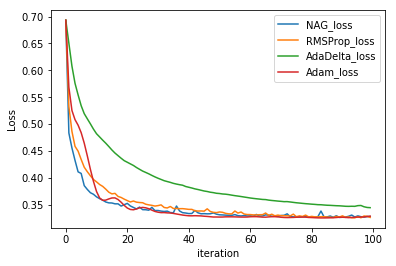

In [26]:
if __name__ == '__main__':

    logistic_regression()